## Research Paper : Hierarchical Network Intrusion Detection via Sequential Binary and Attack Classification

--- 
### Feature Engineering 

In [437]:
### Libararies we will be using 

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 


In [438]:
### Dataset we will be using 
data = pd.read_csv('../Datasets/final_dataset.csv')
data.drop(columns=['Unnamed: 0'], inplace = True)
data.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


### Lets see the structure of our dataset



In [439]:
print(f"The shape of our dataset is {data.shape}, with {data.shape[0]} as total number of samples and {data.shape[1]} as total nubmer of features ")

The shape of our dataset is (148517, 65), with 148517 as total number of samples and 65 as total nubmer of features 


### Quick Stats

### Lets check the total number of null values, missing values and the overview of the data 

In [440]:
print(data.isnull().sum())

duration          0
src_bytes         0
dst_bytes         0
land              0
wrong_fragment    0
                 ..
flag_S1           0
flag_S2           0
flag_S3           0
flag_SF           0
flag_SH           0
Length: 65, dtype: int64


In [441]:
## Overview of the data 
print(data.describe)

<bound method NDFrame.describe of         duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0              0        491          0     0               0       0    0   
1              0        146          0     0               0       0    0   
2              0          0          0     0               0       0    0   
3              0        232       8153     0               0       0    0   
4              0        199        420     0               0       0    0   
...          ...        ...        ...   ...             ...     ...  ...   
148512         0        794        333     0               0       0    0   
148513         0        317        938     0               0       0    0   
148514         0      54540       8314     0               0       0    2   
148515         0         42         42     0               0       0    0   
148516         0          0          0     0               0       0    0   

        num_failed_logins  logged_in  num

---
## Target Column Creation 



In [442]:
### Creating the target columns 
## Malicious vs benign data 

data['is_malicious'] = data['attack'].apply(lambda x: 1 if x != 'normal' else 0 )

print(data['is_malicious'].value_counts())

is_malicious
0    77054
1    71463
Name: count, dtype: int64


In [443]:
## The another target column is Prediciting Attack Severity Level 

severity_mapping = {
    # Level 0: Normal traffic
    'normal': 'Normal',
    
    # Level 1: LOW SEVERITY - Reconnaissance
    'ipsweep': 'Low',       # Network mapping
    'nmap': 'Low',          # Port scanning
    'portsweep': 'Low',     # Port scanning
    'satan': 'Low',         # Security scanner
    'mscan': 'Low',         # Mass scanner
    'saint': 'Low',         # Security scanner
    
    # Level 2: MEDIUM SEVERITY - Availability attacks
    'back': 'Medium',       # DoS
    'land': 'Medium',       # DoS
    'neptune': 'Medium',    # SYN flood
    'pod': 'Medium',        # Ping of death
    'smurf': 'Medium',      # ICMP flood
    'teardrop': 'Medium',   # DoS
    'apache2': 'Medium',    # DoS
    'udpstorm': 'Medium',   # DoS
    'processtable': 'Medium', # DoS
    'worm': 'Medium',       # Self-propagating
    
    # Level 3: HIGH SEVERITY - Unauthorized access
    'guess_passwd': 'High',     # Brute force
    'ftp_write': 'High',        # File upload
    'imap': 'High',             # Mail access
    'phf': 'High',              # CGI exploit
    'multihop': 'High',         # Multi-stage
    'warezmaster': 'High',      # Illegal software
    'warezclient': 'High',      # Illegal software client
    'spy': 'High',              # Spyware
    'xlock': 'High',            # Lockout attack
    'xsnoop': 'High',           # Snooping
    'snmpguess': 'High',        # SNMP brute force
    'snmpgetattack': 'High',    # SNMP exploit
    'httptunnel': 'High',       # Tunneling
    'sendmail': 'High',         # Mail exploit
    'named': 'High',            # DNS exploit
    'buffer_overflow': 'High',  # Memory corruption
    'loadmodule': 'High',       # Kernel module
    'perl': 'High',             # Script execution
    'rootkit': 'High',          # Rootkit
    'sqlattack': 'High',        # SQL injection
    'xterm': 'High',            # Remote terminal
    'ps': 'High'                # Process attack
}

data['Severity_Level'] = data['attack'].map(severity_mapping)
data['Severity_Score'] = data['Severity_Level'].map({'Normal':0,'Medium':2, 'Low':1, 'High': 3})
print(data['Severity_Level'].value_counts(normalize = True))


Severity_Level
Normal    0.519848
Medium    0.358201
Low       0.094971
High      0.026979
Name: proportion, dtype: float64


In [444]:
### Dropping the Severity Level and attack column 
data.drop(columns = ['Severity_Level', 'attack'], inplace = True)

---
## Data Pre-Processing


### Checking skewness of all the numerical features !

In [445]:
### selecting only the numerical columns leaving the binary columns
not_target_data = data.drop(columns = ['is_malicious','Severity_Score'])
only_numeric_data = not_target_data.select_dtypes('int64', 'float64')

### Out of this features lets compute the features which are non-binary 

non_binary_features = []
for col in only_numeric_data.columns:
    unique_values = data[col].unique()
    if len(unique_values) > 2:
        non_binary_features.append(col)
    elif set(unique_values) != {0,1}:
        non_binary_features.append(col)


In [446]:
### Checking the skewness of the non-binary features
non_binary_skew = not_target_data[non_binary_features].skew()
highly_skewed_columns = not_target_data[non_binary_features].columns[non_binary_skew >= 1]

for col in highly_skewed_columns:
    data[col] = np.log1p(data[col]) ## Here log1p is used to avoid the log(0) = Inf error

print(data[non_binary_features].skew())

duration               4.794398
src_bytes              0.331625
dst_bytes              0.450255
wrong_fragment        11.693862
urgent                97.787925
hot                    8.955275
num_failed_logins     16.825191
num_compromised       26.778624
su_attempted          43.760561
num_root              27.550960
num_file_creations    33.187829
num_shells            53.306905
num_access_files      23.439835
count                  0.171397
srv_count              0.944197
dst_host_count        -0.870274
dst_host_srv_count     0.219302
level                 -2.898413
dtype: float64


---
### Checking the variance of the columns 




In [447]:
numerical_variance_datas = not_target_data.select_dtypes('int','float')
variance_of_numerical_data = numerical_variance_datas.var()

less_varied_data = variance_of_numerical_data[variance_of_numerical_data <= 0.001]

print(less_varied_data)

land             0.000215
urgent           0.000377
num_shells       0.000767
is_host_login    0.000081
flag_OTH         0.000337
flag_RSTOS0      0.000706
flag_S2          0.000955
dtype: float64


In [448]:
### We have five features which have variance less than 0.001
less_varied_columns = ['land','is_host_login','flag_OTH', 'flag_RSTOS0','flag_S2']
for col in less_varied_columns:
    print(data[col].value_counts())


land
0    148485
1        32
Name: count, dtype: int64
is_host_login
0    148505
1        12
Name: count, dtype: int64
flag_OTH
0    148467
1        50
Name: count, dtype: int64
flag_RSTOS0
0    148412
1       105
Name: count, dtype: int64
flag_S2
0    148375
1       142
Name: count, dtype: int64


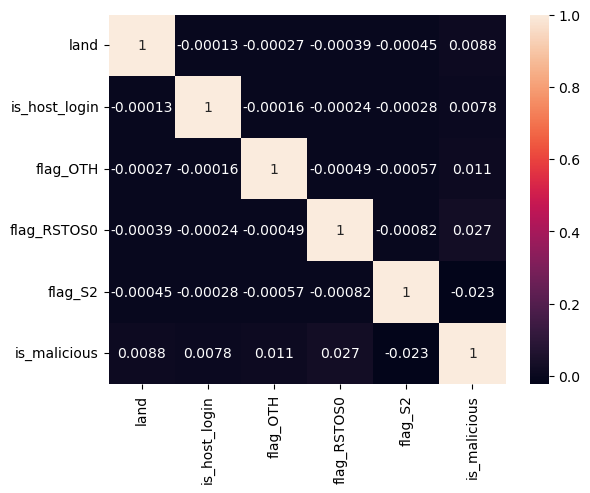

                   land  is_host_login  flag_OTH  flag_RSTOS0   flag_S2  \
land           1.000000      -0.000132 -0.000269    -0.000390 -0.000454   
is_host_login -0.000132       1.000000 -0.000165    -0.000239 -0.000278   
flag_OTH      -0.000269      -0.000165  1.000000    -0.000488 -0.000568   
flag_RSTOS0   -0.000390      -0.000239 -0.000488     1.000000 -0.000823   
flag_S2       -0.000454      -0.000278 -0.000568    -0.000823  1.000000   
is_malicious   0.008817       0.007835  0.010975     0.027113 -0.023252   

               is_malicious  
land               0.008817  
is_host_login      0.007835  
flag_OTH           0.010975  
flag_RSTOS0        0.027113  
flag_S2           -0.023252  
is_malicious       1.000000  


In [449]:
### Lets see the heatmap of the less_varied_columns and the is_malicious column to see how correlated the data are:

columns_to_be_checked = data[['land','is_host_login','flag_OTH','flag_RSTOS0', 'flag_S2', 'is_malicious']]
sns.heatmap(columns_to_be_checked.corr(), annot = True)
plt.show()

print(columns_to_be_checked.corr())


In [450]:
### Looking at the variance of the given columns (<0.001) and also the correlation (< 0.03) of the columns with the target column, the columns have been dropped. Eventhough they carry the security relevance, they have been dropped becuase of statistical insignificance in the models.

data.drop(columns = less_varied_columns, inplace = True)

---
## Feature Engineering 


In [451]:
data['bytes_ratio'] = data['src_bytes'] / (data['dst_bytes'] + 1) ## Added 1 to avoid zero division error
data['total_bytes'] = data['src_bytes'] + data['dst_bytes'] ## Total bytes in the file transfer

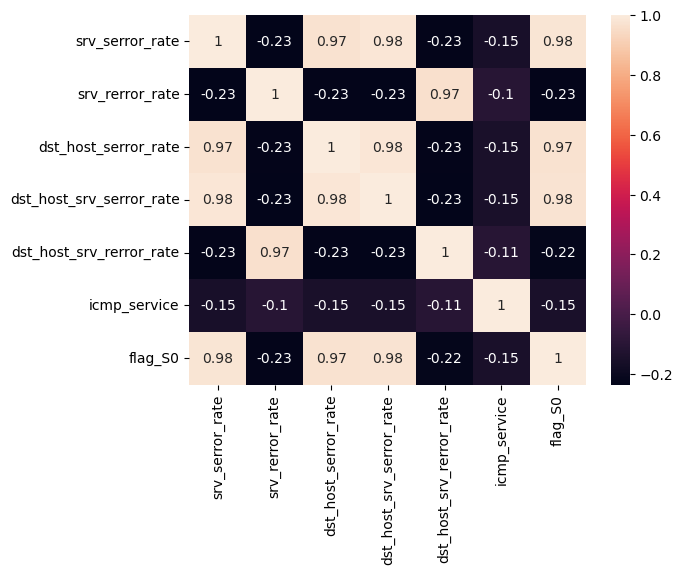

In [452]:
### Checking how correlated are the data with each other
correlated_matrix = data.corr().abs()
upper = correlated_matrix.where(np.triu(np.ones(correlated_matrix.shape), k = 1).astype(bool)) ## To make sure that the same ones get excluded
high_correlated_features = [column for column in upper.columns if any(upper[column] > 0.95)] ## Columns with highly correlated features 
## Heatmap 
sns.heatmap(data[high_correlated_features].corr(), annot = True)
plt.show()

In [453]:
### To be removed_column 
columns_to_be_kept = ['dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate','icmp_service'] 

# since this two columns have provided not only the error rate but also the specific and important details such as same serivce and same destination ip, is the reason why these columns are kept and others are dropped 

columns_to_be_dropped = ['srv_serror_rate','srv_rerror_rate', 'dst_host_serror_rate','flag_S0']
data.drop(columns = columns_to_be_dropped, inplace = True)


### The dataset we will be using for our paper has been finally pre-processed by removing all the less-informative columns. This is the final dataset that we will be using as a part of our paper.

In [ ]:
data.to_csv('../Datasets/pre-processedData.csv')